In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import os
import pickle

def process_clips_for_correlation_test(clips, true_counts, augmentation_labels, model_path):
    """
    Process clips to extract confidence and variance metrics for correlation analysis
    
    Parameters:
    - clips: List of video file paths or clip objects
    - true_counts: List of ground truth counts (same length as clips)
    - augmentation_labels: List of augmentation types ['None', 'blur', 'contrast', 'brightness', etc.]
    - model_path: Path to YOLO model weights (instead of model object)
    
    Returns:
    - results_df: DataFrame with all metrics for analysis
    - frame_variances_data: List of dictionaries with frame-level variance data
    """
    
    clip_results = []
    frame_variances_data = []  # New: store frame-level data
    
    for i, (clip_path, true_count, augmentation) in enumerate(zip(clips, true_counts, augmentation_labels)):
        print(f"Processing clip {i+1}/{len(clips)}: {clip_path} ({augmentation})")
        
        # Initialize lists for this clip
        frame_detection_counts = []
        frame_confidences_all = []
        frame_variances = []
        frame_mean_confidences = []
        unique_track_ids = set()
        
        # Run YOLO tracking on the entire video
        try:
            # Create fresh model instance for each clip to avoid state contamination
            from ultralytics import YOLO
            yolo_model = YOLO(model_path)
            
            yolo_results = yolo_model.track(
                source=clip_path,
                conf=0.7,
                iou=0.45,
                save=False,
                stream=False,
                persist=True,
            )
            
            frame_count = 0
            
            for frame_result in yolo_results:
                # Extract confidences and IDs from this frame
                if hasattr(frame_result, 'boxes') and frame_result.boxes is not None:
                    # Get confidences
                    confidences = frame_result.boxes.conf.cpu().numpy()
                    
                    # Get tracking IDs if available
                    if hasattr(frame_result.boxes, 'id') and frame_result.boxes.id is not None:
                        track_ids = frame_result.boxes.id.cpu().numpy()
                        unique_track_ids.update(track_ids.astype(int))
                    
                else:
                    confidences = np.array([])
                
                # Store frame-level metrics
                frame_detection_count = len(confidences)
                frame_detection_counts.append(frame_detection_count)
                
                if len(confidences) > 0:
                    frame_mean_conf = np.mean(confidences)
                    frame_var_conf = np.var(confidences) if len(confidences) > 1 else 0.0
                    frame_confidences_all.extend(confidences.tolist())
                else:
                    frame_mean_conf = 0.0
                    frame_var_conf = 0.0
                
                frame_mean_confidences.append(frame_mean_conf)
                frame_variances.append(frame_var_conf)
                
                # Store frame-level data for detailed analysis
                frame_variances_data.append({
                    'clip_index': i,
                    'clip_path': clip_path,
                    'augmentation_type': augmentation,
                    'frame_number': frame_count,
                    'detection_count': frame_detection_count,
                    'mean_confidence': frame_mean_conf,
                    'variance': frame_var_conf,
                    'confidences': confidences.tolist(),
                    'true_count': true_count
                })
                
                frame_count += 1
                
        except Exception as e:
            print(f"  Error processing clip: {e}")
            # Fallback to empty results
            frame_count = 0
            unique_track_ids = set()
            frame_detection_counts = [0]
            frame_confidences_all = [0]
            frame_variances = [0]
            frame_mean_confidences = [0]
            
            # Add error frame data
            frame_variances_data.append({
                'clip_index': i,
                'clip_path': clip_path,
                'augmentation_type': augmentation,
                'frame_number': 0,
                'detection_count': 0,
                'mean_confidence': 0.0,
                'variance': 0.0,
                'confidences': [],
                'true_count': true_count,
                'error': str(e)
            })
        
        # Calculate clip-level metrics
        tracking_count = len(unique_track_ids)  # This is the key metric - unique objects tracked
        mean_detection_count = np.mean(frame_detection_counts)  # Average detections per frame
        
        clip_metrics = {
            'clip_index': i,
            'clip_path': clip_path,
            'augmentation': augmentation,
            'is_good_clip': augmentation == 'None',
            'true_count': true_count,
            'total_frames': frame_count,
            
            # Tracking-based count metrics (PRIMARY)
            'tracking_count': tracking_count,
            'tracking_accuracy': 1 - abs(tracking_count - true_count) / true_count if true_count > 0 else 0,
            'tracking_error': abs(tracking_count - true_count),
            'relative_tracking_error': abs(tracking_count - true_count) / true_count if true_count > 0 else float('inf'),
            
            # Frame-based detection metrics (SECONDARY - for comparison)
            'mean_detection_count': mean_detection_count,
            'std_detection_count': np.std(frame_detection_counts),
            'detection_cv': np.std(frame_detection_counts) / mean_detection_count if mean_detection_count > 0 else 0,
            'detection_accuracy': 1 - abs(mean_detection_count - true_count) / true_count if true_count > 0 else 0,
            'detection_error': abs(mean_detection_count - true_count),
            
            # Confidence metrics (traditional monitoring)
            'mean_confidence': np.mean(frame_mean_confidences),
            'std_confidence': np.std(frame_mean_confidences),
            'overall_mean_confidence': np.mean(frame_confidences_all) if frame_confidences_all else 0,
            'overall_std_confidence': np.std(frame_confidences_all) if len(frame_confidences_all) > 1 else 0,
            
            # Variance metrics (your approach)
            'mean_variance': np.mean(frame_variances),
            'std_variance': np.std(frame_variances),
            'max_variance': np.max(frame_variances),
            'variance_90th_percentile': np.percentile(frame_variances, 90),
            'variance_cv': np.std(frame_variances) / np.mean(frame_variances) if np.mean(frame_variances) > 0 else 0,
            
            # Store raw data for Bayesian monitor
            'raw_variances': frame_variances.copy()
        }
        
        clip_results.append(clip_metrics)
        
        print(f"  Augmentation: {augmentation}")
        print(f"  Frames: {frame_count}")
        print(f"  Unique tracked objects: {tracking_count} (true: {true_count})")
        print(f"  Tracking accuracy: {clip_metrics['tracking_accuracy']:.3f}")
        print(f"  Mean detections/frame: {clip_metrics['mean_detection_count']:.2f}")
        print(f"  Mean confidence: {clip_metrics['mean_confidence']:.3f}")
        print(f"  Mean variance: {clip_metrics['mean_variance']:.6f}")
        print()
    
    return pd.DataFrame(clip_results), frame_variances_data

def run_correlation_analysis(results_df):
    """
    Run Spearman correlation analysis between different metrics and count accuracy
    """
    print("="*60)
    print("SPEARMAN CORRELATION ANALYSIS: VARIANCE vs CONFIDENCE MONITORING")
    print("="*60)
    
    # Define metrics to test
    variance_metrics = [
        ('mean_variance', 'Mean Confidence Variance'),
        ('variance_90th_percentile', '90th Percentile Variance'),
        ('max_variance', 'Maximum Variance'),
        ('variance_cv', 'Variance Coefficient of Variation')
    ]
    
    confidence_metrics = [
        ('mean_confidence', 'Mean Confidence Score'),
        ('overall_mean_confidence', 'Overall Mean Confidence'),
        ('std_confidence', 'Confidence Standard Deviation')
    ]
    
    target_metrics = [
        ('tracking_accuracy', 'Tracking Accuracy'),
        ('relative_tracking_error', 'Relative Tracking Error (higher = worse)'),
        ('detection_accuracy', 'Detection Accuracy (frame-based)'),
        ('detection_cv', 'Detection Count Variability')
    ]
    
    correlation_results = {}
    
    print("\nVARIANCE-BASED METRICS:")
    print("-" * 40)
    
    for var_metric, var_name in variance_metrics:
        print(f"\n{var_name}:")
        for target_metric, target_name in target_metrics:
            if target_metric in results_df.columns:
                # Remove any infinite values
                valid_data = results_df[[var_metric, target_metric]].replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(valid_data) >= 3:
                    x = valid_data[var_metric]
                    y = valid_data[target_metric]
                    
                    spearman_r, spearman_p = spearmanr(x, y)
                    
                    correlation_results[f"{var_metric}_vs_{target_metric}"] = {
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n_samples': len(valid_data),
                        'metric_type': 'variance'
                    }
                    
                    print(f"  vs {target_name}:")
                    print(f"    Spearman: r = {spearman_r:6.3f}, p = {spearman_p:.3f}")
    
    print("\n\nCONFIDENCE-BASED METRICS (Traditional Monitoring):")
    print("-" * 50)
    
    for conf_metric, conf_name in confidence_metrics:
        print(f"\n{conf_name}:")
        for target_metric, target_name in target_metrics:
            if target_metric in results_df.columns:
                valid_data = results_df[[conf_metric, target_metric]].replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(valid_data) >= 3:
                    x = valid_data[conf_metric]
                    y = valid_data[target_metric]
                    
                    spearman_r, spearman_p = spearmanr(x, y)
                    
                    correlation_results[f"{conf_metric}_vs_{target_metric}"] = {
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n_samples': len(valid_data),
                        'metric_type': 'confidence'
                    }
                    
                    print(f"  vs {target_name}:")
                    print(f"    Spearman: r = {spearman_r:6.3f}, p = {spearman_p:.3f}")
    
    return correlation_results

def save_frame_variances_for_bayesian_test(frame_variances_data, save_dir='/saved_data'):
    """
    Save frame variances in the format expected by the Bayesian test
    """
    # Create directory
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n=== SAVING FRAME VARIANCES FOR BAYESIAN TEST ===")
    
    # Group frame variances by clip
    clips_data = {}
    for frame_info in frame_variances_data:
        clip_idx = frame_info['clip_index']
        if clip_idx not in clips_data:
            clips_data[clip_idx] = {
                'variances': [],
                'clip_path': frame_info['clip_path'],
                'augmentation_type': frame_info['augmentation_type']
            }
        clips_data[clip_idx]['variances'].append(frame_info['variance'])
    
    # Convert to the expected structure
    frame_variances = []
    clip_paths = []
    labels = []
    augmentation_types = []
    
    for clip_idx in sorted(clips_data.keys()):
        clip_data = clips_data[clip_idx]
        
        frame_variances.append(clip_data['variances'])
        clip_paths.append(clip_data['clip_path'])
        augmentation_types.append(clip_data['augmentation_type'])
        
        # Label: 0 for 'None' (good), 1 for degraded
        labels.append(0 if clip_data['augmentation_type'] == 'None' else 1)
    
    # Create the structure the Bayesian test expects
    bayesian_data = {
        'frame_variances': frame_variances,
        'clip_paths': clip_paths,
        'labels': labels,
        'augmentation_types': augmentation_types
    }
    
    # Save the frame variances file
    frame_variances_path = os.path.join(save_dir, 'frame_variances.pkl')
    with open(frame_variances_path, 'wb') as f:
        pickle.dump(bayesian_data, f)
    
    print(f"✓ Frame variances saved for Bayesian test: {frame_variances_path}")
    print(f"Structure: {len(frame_variances)} clips")
    print(f"Augmentation types: {set(augmentation_types)}")
    print(f"Labels: {sum(labels)} degraded, {len(labels) - sum(labels)} good")
    
    # Verify the save worked
    try:
        with open(frame_variances_path, 'rb') as f:
            test_load = pickle.load(f)
        print(f"✓ Verification: Successfully loaded {len(test_load['frame_variances'])} clips")
    except Exception as e:
        print(f"✗ Verification failed: {e}")
    
    return frame_variances_path

def save_data_to_directory(results_df, correlations, frame_variances_data, save_dir='saved_data'):
    """
    Save correlation data to the specified directory
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\n=== SAVING DATA ===")
    print(f"Save directory: {save_dir}")
    
    # Save correlation results DataFrame
    correlation_results_path = os.path.join(save_dir, 'correlation_results.pkl')
    results_df.to_pickle(correlation_results_path)
    print(f"✓ Correlation results saved to: {correlation_results_path}")
    
    # Save correlation statistics
    correlation_stats_path = os.path.join(save_dir, 'correlation_statistics.pkl')
    with open(correlation_stats_path, 'wb') as f:
        pickle.dump(correlations, f)
    print(f"✓ Correlation statistics saved to: {correlation_stats_path}")
    
    return {
        'correlation_results': correlation_results_path,
        'correlation_statistics': correlation_stats_path
    }

def plot_key_correlations(results_df, save_plots=True, save_dir='saved_data'):
    """
    Create scatter plots for the most important correlations (Spearman only)
    """
    # Create plots directory
    plots_dir = os.path.join(save_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Define colors for different augmentations
    augmentation_colors = {
        'None': 'green',
        'blur': 'red', 
        'contrast': 'orange',
        'brightness': 'purple',
        'noise': 'brown',
        'occlusion': 'blue'
    }
    
    # Get colors for each clip
    colors = [augmentation_colors.get(aug, 'gray') for aug in results_df['augmentation']]
    
    # Create first figure: Main correlation plots
    fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Mean Variance vs Tracking Accuracy
    ax = axes1[0]
    scatter1 = ax.scatter(results_df['mean_variance'], results_df['tracking_accuracy'], 
                         c=colors, s=100, alpha=0.7)
    
    # Add Spearman correlation info
    r, p = spearmanr(results_df['mean_variance'], results_df['tracking_accuracy'])
    ax.text(0.05, 0.15, f'ρ = {r:.3f}\np = {p:.3f}', transform=ax.transAxes, 
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Mean Confidence Variance')
    ax.set_ylabel('Tracking Accuracy')
    ax.set_title('Variance-Based Monitoring vs Tracking Performance')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Mean Confidence vs Tracking Accuracy
    ax = axes1[1]
    scatter2 = ax.scatter(results_df['mean_confidence'], results_df['tracking_accuracy'], 
                         c=colors, s=100, alpha=0.7)
    
    r, p = spearmanr(results_df['mean_confidence'], results_df['tracking_accuracy'])
    ax.text(0.05, 0.15, f'ρ = {r:.3f}\np = {p:.3f}', transform=ax.transAxes, 
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Mean Confidence Score')
    ax.set_ylabel('Tracking Accuracy')
    ax.set_title('Traditional Confidence Monitoring vs Tracking Performance')
    ax.grid(True, alpha=0.3)
    
    # Add shared legend centered below both plots
    legend_elements = [plt.scatter([], [], c=color, s=100, label=aug_type, alpha=0.7) 
                      for aug_type, color in augmentation_colors.items() 
                      if aug_type in results_df['augmentation'].values]
    
    fig1.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(legend_elements))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Make room for the legend
    if save_plots:
        plot_path = os.path.join(plots_dir, 'correlation_comparison.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {plot_path}")
    plt.show()
    
    # Create second figure: Variance vs Tracking Error
    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
    
    scatter3 = ax2.scatter(results_df['mean_variance'], results_df['tracking_error'], 
                          c=colors, s=100, alpha=0.7)
    
    r, p = spearmanr(results_df['mean_variance'], results_df['tracking_error'])
    ax2.text(0.05, 0.95, f'ρ = {r:.3f}\np = {p:.3f}', transform=ax2.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.set_xlabel('Mean Confidence Variance')
    ax2.set_ylabel('Tracking Error (Absolute)')
    ax2.set_title('Variance vs Tracking Error')
    ax2.grid(True, alpha=0.3)
    
    # Add legend to upper right of second figure (moved away from correlation text)
    legend_elements2 = [plt.scatter([], [], c=color, s=100, label=aug_type, alpha=0.7) 
                       for aug_type, color in augmentation_colors.items() 
                       if aug_type in results_df['augmentation'].values]
    
    ax2.legend(handles=legend_elements2, loc='upper right')
    
    plt.tight_layout()
    if save_plots:
        plot_path = os.path.join(plots_dir, 'variance_vs_error.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {plot_path}")
    plt.show()

def main_test_loop(clips, true_counts, augmentation_labels, model_path, save_dir='saved_data'):
    """
    Main function to run the complete correlation test with Spearman correlations
    """
    
    print("Starting YOLO clip processing for correlation analysis...")
    print(f"Processing {len(clips)} clips with {len(true_counts)} ground truth counts")
    print(f"Augmentation types: {set(augmentation_labels)}")
    print(f"Model path: {model_path}")
    print(f"Save directory: {save_dir}")
    
    # Process all clips
    results_df, frame_variances_data = process_clips_for_correlation_test(clips, true_counts, augmentation_labels, model_path)
    
    # Debug: Check if frame variances data was created
    print(f"\nDEBUG: Collected {len(frame_variances_data)} frame variance entries")
    if frame_variances_data:
        print(f"Sample entry: {frame_variances_data[0]}")
    
    # Run correlation analysis
    correlations = run_correlation_analysis(results_df)
    
    # Save correlation data
    saved_files = save_data_to_directory(results_df, correlations, frame_variances_data, save_dir)
    
    # Save frame variances in Bayesian test format
    frame_variances_path = save_frame_variances_for_bayesian_test(frame_variances_data, save_dir)
    saved_files['frame_variances'] = frame_variances_path
    
    # Create plots
    plot_key_correlations(results_df, save_plots=True, save_dir=save_dir)
    
    # Print augmentation-specific analysis
    print("\n" + "="*60)
    print("ANALYSIS BY AUGMENTATION TYPE")
    print("="*60)
    
    for aug_type in results_df['augmentation'].unique():
        aug_data = results_df[results_df['augmentation'] == aug_type]
        print(f"\n{aug_type.upper()} clips (n={len(aug_data)}):")
        print(f"  Mean tracking accuracy:   {aug_data['tracking_accuracy'].mean():.3f} (±{aug_data['tracking_accuracy'].std():.3f})")
        print(f"  Mean tracking count:      {aug_data['tracking_count'].mean():.1f} (±{aug_data['tracking_count'].std():.1f})")
        print(f"  Mean variance:            {aug_data['mean_variance'].mean():.6f} (±{aug_data['mean_variance'].std():.6f})")
        print(f"  Mean confidence:          {aug_data['mean_confidence'].mean():.3f} (±{aug_data['mean_confidence'].std():.3f})")
        print(f"  Detection CV (stability): {aug_data['detection_cv'].mean():.3f} (±{aug_data['detection_cv'].std():.3f})")
    
    # Print summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    
    # Find strongest correlations (Spearman only)
    variance_corrs = [(k, v) for k, v in correlations.items() 
                     if v['metric_type'] == 'variance' and 'tracking_accuracy' in k]
    confidence_corrs = [(k, v) for k, v in correlations.items() 
                       if v['metric_type'] == 'confidence' and 'tracking_accuracy' in k]
    
    if variance_corrs:
        best_var = max(variance_corrs, key=lambda x: abs(x[1]['spearman_r']))
        print(f"Best variance correlation: {best_var[0]}")
        print(f"  Spearman ρ = {best_var[1]['spearman_r']:.3f}, p = {best_var[1]['spearman_p']:.3f}")
    
    if confidence_corrs:
        best_conf = max(confidence_corrs, key=lambda x: abs(x[1]['spearman_r']))
        print(f"Best confidence correlation: {best_conf[0]}")
        print(f"  Spearman ρ = {best_conf[1]['spearman_r']:.3f}, p = {best_conf[1]['spearman_p']:.3f}")
    
    # Count how many augmented clips were correctly identified as having issues
    good_clips = results_df[results_df['augmentation'] == 'None']
    bad_clips = results_df[results_df['augmentation'] != 'None']
    
    if len(good_clips) > 0 and len(bad_clips) > 0:
        print(f"\nTracking Performance Comparison:")
        print(f"Good clips average accuracy:  {good_clips['tracking_accuracy'].mean():.3f}")
        print(f"Bad clips average accuracy:   {bad_clips['tracking_accuracy'].mean():.3f}")
        print(f"Good clips average count:     {good_clips['tracking_count'].mean():.1f}")
        print(f"Bad clips average count:      {bad_clips['tracking_count'].mean():.1f}")
        
        print(f"\nVariance Monitoring Sensitivity:")
        print(f"Good clips average variance:  {good_clips['mean_variance'].mean():.6f}")
        print(f"Bad clips average variance:   {bad_clips['mean_variance'].mean():.6f}")
        
        print(f"\nConfidence Monitoring Sensitivity:")
        print(f"Good clips average confidence: {good_clips['mean_confidence'].mean():.3f}")
        print(f"Bad clips average confidence:  {bad_clips['mean_confidence'].mean():.3f}")
    
    print(f"\n" + "="*60)
    print("FILES SAVED")
    print("="*60)
    for file_type, file_path in saved_files.items():
        print(f"{file_type}: {file_path}")
    
    return results_df, correlations, frame_variances_data, saved_files

# Utility function for loading saved data
def load_saved_data(save_dir='saved_data'):
    """
    Load all saved data from the directory
    
    Returns:
    - results_df: Correlation results DataFrame  
    - correlations: Correlation statistics dictionary
    - frame_variances_data: Frame variances in Bayesian test format
    """
    results_df = pd.read_pickle(os.path.join(save_dir, 'correlation_results.pkl'))
    
    with open(os.path.join(save_dir, 'correlation_statistics.pkl'), 'rb') as f:
        correlations = pickle.load(f)
    
    with open(os.path.join(save_dir, 'frame_variances.pkl'), 'rb') as f:
        frame_variances_data = pickle.load(f)
    
    return results_df, correlations, frame_variances_data


Starting YOLO clip processing for correlation analysis...
Processing 10 clips with 10 ground truth counts
Augmentation types: {'None', 'blur'}
Model path: runs/detect/meatball_yolo/weights/best.pt
Save directory: saved_data
Processing clip 1/10: ../data/raw/UncertaintyClips/clip_0017.mp4 (None)


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/453) c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\..\data\raw\UncertaintyClips\clip_0017.mp4: 640x640 51 class0s, 106.1ms
video 1

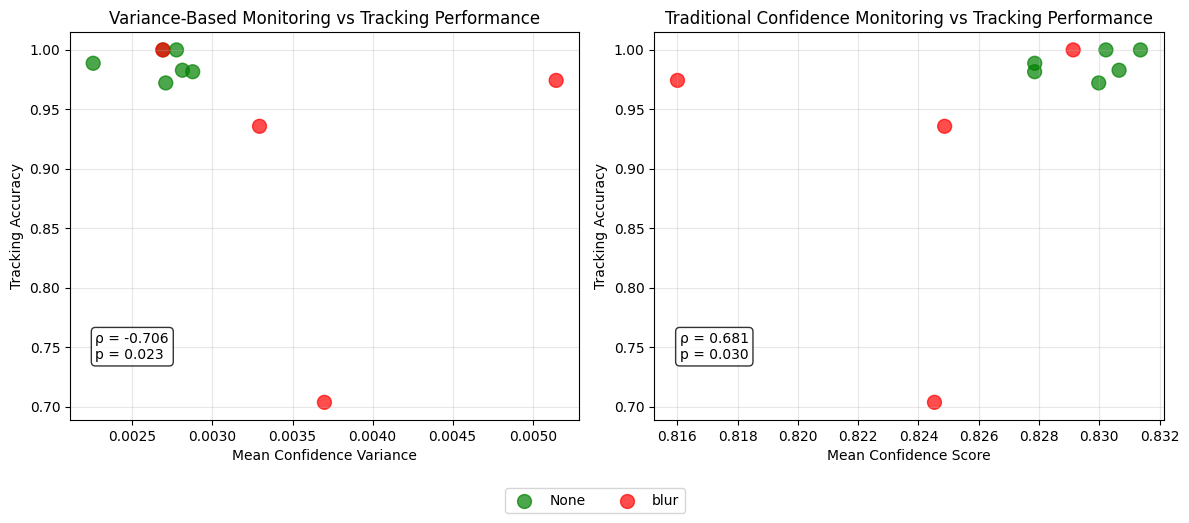

Plot saved to: saved_data\plots\variance_vs_error.png


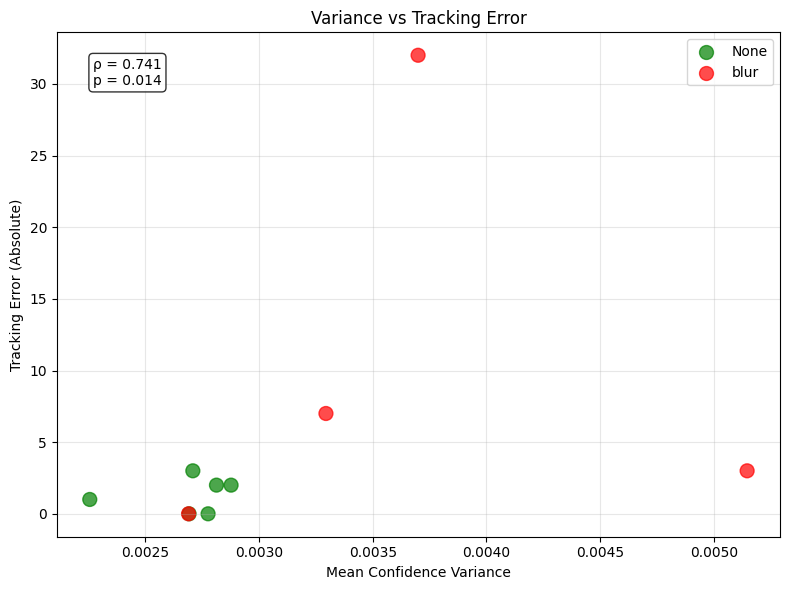


ANALYSIS BY AUGMENTATION TYPE

NONE clips (n=6):
  Mean tracking accuracy:   0.988 (±0.011)
  Mean tracking count:      107.8 (±9.6)
  Mean variance:            0.002687 (±0.000222)
  Mean confidence:          0.830 (±0.001)
  Detection CV (stability): 0.071 (±0.079)

BLUR clips (n=4):
  Mean tracking accuracy:   0.903 (±0.136)
  Mean tracking count:      121.0 (±13.6)
  Mean variance:            0.003707 (±0.001045)
  Mean confidence:          0.824 (±0.006)
  Detection CV (stability): 0.040 (±0.009)

SUMMARY
Best variance correlation: mean_variance_vs_tracking_accuracy
  Spearman ρ = -0.706, p = 0.023
Best confidence correlation: mean_confidence_vs_tracking_accuracy
  Spearman ρ = 0.681, p = 0.030

Tracking Performance Comparison:
Good clips average accuracy:  0.988
Bad clips average accuracy:   0.903
Good clips average count:     107.8
Bad clips average count:      121.0

Variance Monitoring Sensitivity:
Good clips average variance:  0.002687
Bad clips average variance:   0.003707


In [17]:
from ultralytics import YOLO


# Load your trained model
model_path = "runs/detect/meatball_yolo/weights/best.pt"  # Update this to your model path

clips = [
    "../data/raw/UncertaintyClips/clip_0017.mp4",
    "../data/raw/UncertaintyClips/clip_0018.mp4",
    "../data/raw/UncertaintyClips/clip_0019.mp4",
    "../data/raw/UncertaintyClips/clip_0020.mp4",
    "../data/raw/UncertaintyClips/clip_0021.mp4",
    "../data/raw/UncertaintyClips/clip_0022.mp4",
    "../data/raw/UncertaintyClips/clip_0023.mp4",
    "../data/raw/UncertaintyClips/clip_0024.mp4",
    "../data/raw/UncertaintyClips/clip_0025.mp4",
    "../data/raw/UncertaintyClips/clip_0026.mp4",
    # "../data/raw/UncertaintyClips/clip_0027.mp4",
    # "../data/raw/UncertaintyClips/clip_0028.mp4",
    # "../data/raw/UncertaintyClips/clip_0029.mp4",
    # "../data/raw/UncertaintyClips/clip_0030.mp4",
    # "../data/raw/UncertaintyClips/clip_0031.mp4",
    # "../data/raw/UncertaintyClips/clip_0032.mp4",
    # "../data/raw/UncertaintyClips/clip_0033.mp4",
    # "../data/raw/UncertaintyClips/clip_0034.mp4",
    # "../data/raw/UncertaintyClips/clip_0035.mp4",
    # "../data/raw/UncertaintyClips/clip_0036.mp4",
    # "../data/raw/UncertaintyClips/clip_0037.mp4",
    # "../data/raw/UncertaintyClips/clip_0038.mp4",
    # "../data/raw/UncertaintyClips/clip_0039.mp4",
    # "../data/raw/UncertaintyClips/clip_0040.mp4",
    # "../data/raw/UncertaintyClips/clip_0041.mp4",
    # "../data/raw/UncertaintyClips/clip_0042.mp4",
    # "../data/raw/UncertaintyClips/clip_0043.mp4",
    # "../data/raw/UncertaintyClips/clip_0044.mp4",
    # "../data/raw/UncertaintyClips/clip_0045.mp4",
    # "../data/raw/UncertaintyClips/clip_0046.mp4",
]


true_counts = [
    109, 108, 108, 117, 108, 89,  # counts for original good clips
    109, 108, 108, 117, # 108, 89,  # same counts for degraded versions
    # 109, 108, 108, 117, 108, 89,  # same counts for degraded versions
    # 109, 108, 108, 117, 108, 89,  # same counts for degraded versions
    # 109, 108, 108, 117, 108, 89,  # same counts for degraded versions
]

augmentation_labels = [
    'None', 'None', 'None', 'None', 'None', 'None',  # good clips
    'blur', 'blur', 'blur', 'blur',# 'blur', 'blur',  # bad clips
    # 'contrast', 'contrast', 'contrast', 'contrast', 'contrast', 'contrast',  # bad clips
    # 'brightness', 'brightness', 'brightness', 'brightness', 'brightness', 'brightness', # bad clips
    # 'occlusion', 'occlusion', 'occlusion', 'occlusion', 'occlusion', 'occlusion', # bad clips
]


# Run the test
results_df, correlations, frame_variances_data, saved_files = main_test_loop(clips, true_counts, augmentation_labels, model_path)

# Normal frame variance

In [ ]:
import numpy as np
import pickle
from ultralytics import YOLO

# Your setup
model_path = "runs/detect/meatball_yolo/weights/best.pt"

clips = [
    "../data/raw/UncertaintyClips/clip_0017.mp4",
    "../data/raw/UncertaintyClips/clip_0018.mp4",
    "../data/raw/UncertaintyClips/clip_0019.mp4",
    "../data/raw/UncertaintyClips/clip_0020.mp4",
    "../data/raw/UncertaintyClips/clip_0021.mp4",
    "../data/raw/UncertaintyClips/clip_0022.mp4",
    "../data/raw/UncertaintyClips/clip_0023.mp4",
    "../data/raw/UncertaintyClips/clip_0024.mp4",
    "../data/raw/UncertaintyClips/clip_0025.mp4",
    "../data/raw/UncertaintyClips/clip_0026.mp4",
]

augmentation_labels = [
    'None', 'None', 'None', 'None', 'None', 'None',
    'blur', 'blur', 'blur', 'blur'
]

# Load model
model = YOLO(model_path)

# Process clips
frame_variances = []
clip_paths = []
labels = []
augmentation_types = []

for i, (clip_path, augmentation) in enumerate(zip(clips, augmentation_labels)):
    print(f"Processing clip {i+1}/{len(clips)}: {clip_path}")
    
    # Run YOLO tracking
    results = model.track(source=clip_path, conf=0.3, iou=0.45, save=False, stream=False, persist=True)
    
    # Extract frame variances
    clip_variances = []
    for frame_result in results:
        if hasattr(frame_result, 'boxes') and frame_result.boxes is not None:
            confidences = frame_result.boxes.conf.cpu().numpy()
            if len(confidences) > 1:
                variance = np.var(confidences)
            else:
                variance = 0.0
        else:
            variance = 0.0
        clip_variances.append(variance)
    
    # Store in Bayesian test format
    frame_variances.append(clip_variances)
    clip_paths.append(clip_path)
    augmentation_types.append(augmentation)
    labels.append(0 if augmentation == 'None' else 1)  # 0=good, 1=degraded

# Save in correct format
bayesian_data = {
    'frame_variances': frame_variances,
    'clip_paths': clip_paths,
    'labels': labels,
    'augmentation_types': augmentation_types
}

with open('frame_variances.pkl', 'wb') as f:
    pickle.dump(bayesian_data, f)

print(f"Saved frame variances for {len(frame_variances)} clips")
print(f"Structure: {len(frame_variances)} clips with variance arrays")
print(f"Augmentation types: {set(augmentation_types)}")
print(f"Labels: {sum(labels)} degraded, {len(labels) - sum(labels)} good")

# Dropout Frame variance

In [ ]:
import numpy as np
import pickle
import sys

# Add the path to your MCDropoutTracker class
sys.path.append('../src/master')  # or whatever the correct path is

try:
    from dropoutYOLO import MCDropoutTracker
except ImportError:
    print("Could not import MCDropoutTracker. Please check the path.")
    raise

# Your setup
model_path = "runs/detect/mc_tuned_meatball/weights/best.pt"

clips = [
    "../data/raw/UncertaintyClips/clip_0017.mp4",
    "../data/raw/UncertaintyClips/clip_0018.mp4",
    "../data/raw/UncertaintyClips/clip_0019.mp4",
    "../data/raw/UncertaintyClips/clip_0020.mp4",
    "../data/raw/UncertaintyClips/clip_0021.mp4",
    "../data/raw/UncertaintyClips/clip_0022.mp4",
    "../data/raw/UncertaintyClips/clip_0023.mp4",
    "../data/raw/UncertaintyClips/clip_0024.mp4",
    "../data/raw/UncertaintyClips/clip_0025.mp4",
    "../data/raw/UncertaintyClips/clip_0026.mp4",
]

augmentation_labels = [
    'None', 'None', 'None', 'None', 'None', 'None',
    'blur', 'blur', 'blur', 'blur'
]

# Initialize MC Dropout tracker
mc_tracker = MCDropoutTracker(model_path, dropout_rate=0.01)

# Process clips with 10 MC runs
frame_variances = []
clip_paths = []
labels = []
augmentation_types = []

for i, (clip_path, augmentation) in enumerate(zip(clips, augmentation_labels)):
    print(f"Processing clip {i+1}/{len(clips)}: {clip_path}")
    
    # Run 10 MC dropout iterations
    all_runs_variances = []
    
    for run in range(10):
        print(f"  MC Run {run+1}/10")
        
        # Run YOLO tracking with MC dropout (fresh model each time)
        results = mc_tracker.track(
            source=clip_path, 
            conf=0.3, 
            iou=0.45, 
            save=False, 
            stream=False, 
            persist=True,
            fresh_model=True
        )
        
        # Extract frame variances for this run
        run_variances = []
        for frame_result in results:
            if hasattr(frame_result, 'boxes') and frame_result.boxes is not None:
                confidences = frame_result.boxes.conf.cpu().numpy()
                if len(confidences) > 1:
                    variance = np.var(confidences)
                else:
                    variance = 0.0
            else:
                variance = 0.0
            run_variances.append(variance)
        
        all_runs_variances.append(run_variances)
    
    # Average variances across all 10 runs (same clip = same number of frames)
    if all_runs_variances:
        # All runs should have the same length since it's the same clip
        avg_variances = np.mean(all_runs_variances, axis=0).tolist()
    else:
        avg_variances = [0.0]
    
    # Store in Bayesian test format
    frame_variances.append(avg_variances)
    clip_paths.append(clip_path)
    augmentation_types.append(augmentation)
    labels.append(0 if augmentation == 'None' else 1)  # 0=good, 1=degraded
    
    print(f"  Averaged {len(all_runs_variances)} runs, {len(avg_variances)} frames")

# Save in correct format
bayesian_data = {
    'frame_variances': frame_variances,
    'clip_paths': clip_paths,
    'labels': labels,
    'augmentation_types': augmentation_types
}

with open('frame_variances_mc_dropout.pkl', 'wb') as f:
    pickle.dump(bayesian_data, f)

print(f"\nSaved MC dropout frame variances for {len(frame_variances)} clips")
print(f"Structure: {len(frame_variances)} clips with averaged variance arrays")
print(f"Augmentation types: {set(augmentation_types)}")
print(f"Labels: {sum(labels)} degraded, {len(labels) - sum(labels)} good")
print("Each frame variance is averaged across 10 MC dropout runs")

# Detection test

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from scipy.stats import spearmanr

# Add the path to your BayesianYOLOMonitorJAX class
sys.path.append('../src/master')  # or whatever the correct path is

try:
    from yolo_monitoring import BayesianYOLOMonitorJAX
except ImportError:
    print("Could not import BayesianYOLOMonitorJAX. Please check the path.")
    raise

def load_frame_variances(filepath):
    """Load frame variances from pickle file - now in correct Bayesian format"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    # Data is now already in the correct format:
    # {
    #     'frame_variances': [list of variance arrays, one per clip],
    #     'clip_paths': [list of clip paths],
    #     'labels': [0/1 labels],
    #     'augmentation_types': [augmentation type strings]
    # }
    
    frame_variances = data['frame_variances']
    augmentation_types = data['augmentation_types']
    
    return frame_variances, augmentation_types

def test_bayesian_monitor_with_baseline(filepath, n_baseline):
    """
    Test bayesian monitor with specified number of baseline clips
    """
    print(f"\n--- Testing with {n_baseline} baseline clips ---")
    
    frame_variances, augmentation_types = load_frame_variances(filepath)
    
    # Load correlation results to get count accuracy
    correlation_results_path = filepath.replace('frame_variances.pkl', 'correlation_results.pkl')
    results_df = pd.read_pickle(correlation_results_path)
    
    # Find all 'None' clips
    good_clip_indices = [i for i, aug_type in enumerate(augmentation_types) if aug_type == 'None']
    
    if len(good_clip_indices) < n_baseline:
        print(f"Warning: Only {len(good_clip_indices)} 'None' clips available, requested {n_baseline}")
        return None
    
    # Use first n_baseline 'None' clips as baseline
    baseline_indices = good_clip_indices[:n_baseline]
    baseline_clips = [frame_variances[i] for i in baseline_indices]
    
    # Remaining clips (including unused good clips) are test clips
    test_indices = [i for i in range(len(frame_variances)) if i not in baseline_indices]
    
    print(f"Using {len(baseline_clips)} baseline clips")
    print(f"Testing {len(test_indices)} clips (including {len(good_clip_indices) - n_baseline} unused good clips)")
    
    # Initialize monitor with 5000 samples
    monitor = BayesianYOLOMonitorJAX(
        min_deviation_threshold=0.1,
        credible_interval=0.95,
        mcmc_samples=5000  # Increased to 5000
    )
    
    # Establish baseline with visualization
    monitor.establish_baseline(baseline_clips, visualize=True)
    
    # Test all remaining clips
    probabilities = []
    augmentations = []
    tracking_accuracies = []
    
    for i in test_indices:
        clip_variances = frame_variances[i]
        
        # Get probability of anomaly using only the probabilistic method
        result = monitor.check_performance_probabilistic(clip_variances)
        probabilities.append(result['p_below_threshold'])
        augmentations.append(augmentation_types[i])
        
        # Get tracking accuracy from correlation results
        tracking_accuracy = results_df.iloc[i]['tracking_accuracy']
        tracking_accuracies.append(tracking_accuracy)
    
    # Calculate Spearman correlation
    corr_r, corr_p = spearmanr(probabilities, tracking_accuracies)
    print(f"Spearman correlation: r = {corr_r:.3f}, p = {corr_p:.3f}")
    
    return probabilities, tracking_accuracies, augmentations, corr_r, corr_p

def test_all_baseline_sizes(filepath):
    """
    Test with baseline sizes 1, 2, 3, and 4 and create plots
    """
    print("Loading frame variances data...")
    frame_variances, augmentation_types = load_frame_variances(filepath)
    
    print(f"Loaded {len(frame_variances)} clips")
    print(f"Augmentation types: {set(augmentation_types)}")
    
    all_results = []
    
    for n_baseline in [1, 2, 3, 4]:
        result = test_bayesian_monitor_with_baseline(filepath, n_baseline)
        if result is not None:
            probabilities, accuracies, augmentations, corr_r, corr_p = result
            all_results.append((n_baseline, probabilities, accuracies, augmentations, corr_r, corr_p))
    
    # Create plots for all baseline sizes
    create_all_plots(all_results)
    
    return all_results

def create_all_plots(all_results):
    """
    Create plots for all baseline sizes (2x2 grid)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Define colors for different augmentations
    augmentation_colors = {
        'None': 'green',
        'blur': 'red', 
        'contrast': 'orange',
        'brightness': 'purple',
        'noise': 'brown',
        'occlusion': 'blue'
    }
    
    for i, (n_baseline, probabilities, accuracies, augmentations, corr_r, corr_p) in enumerate(all_results):
        ax = axes[i]
        
        colors = [augmentation_colors.get(aug, 'gray') for aug in augmentations]
        
        # Scatter plot
        ax.scatter(probabilities, accuracies, c=colors, s=100, alpha=0.7)
        
        # Decision boundary
        ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
        
        # Labels and formatting
        ax.set_xlabel('Probability of Anomalous')
        ax.set_ylabel('Count Accuracy')
        ax.set_title(f'{n_baseline} Baseline Clips')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    # Create legend for the entire figure
    legend_elements = [plt.scatter([], [], c=color, s=100, label=aug_type, alpha=0.7) 
                      for aug_type, color in augmentation_colors.items()]
    legend_elements.append(plt.plot([], [], color='black', linestyle='--', linewidth=2, 
                                  alpha=0.5, label='Decision Boundary')[0])
    
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(legend_elements))
    
    plt.suptitle('Bayesian Monitor: Count Accuracy vs Anomaly Probability', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.savefig('bayesian_monitor_all_baselines.png', dpi=300, bbox_inches='tight')
    plt.show()



Loading frame variances data...
Loaded 10 clips
Augmentation types: {'None', 'blur'}

--- Testing with 1 baseline clips ---
Using 1 baseline clips
Testing 9 clips (including 5 unused good clips)
Starting JAX MCMC sampling...


sample: 100%|██████████| 5500/5500 [00:02<00:00, 1993.05it/s, 7 steps of size 5.24e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.76      0.04      0.76      0.69      0.84   1729.72      1.00
      beta    191.53     14.90    191.21    167.00    215.58   1773.83      1.00

Number of divergences: 0
JAX sampling completed in 2.90 seconds (1721.80 samples/sec)


c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\../src/master\yolo_monitoring.py:468: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',


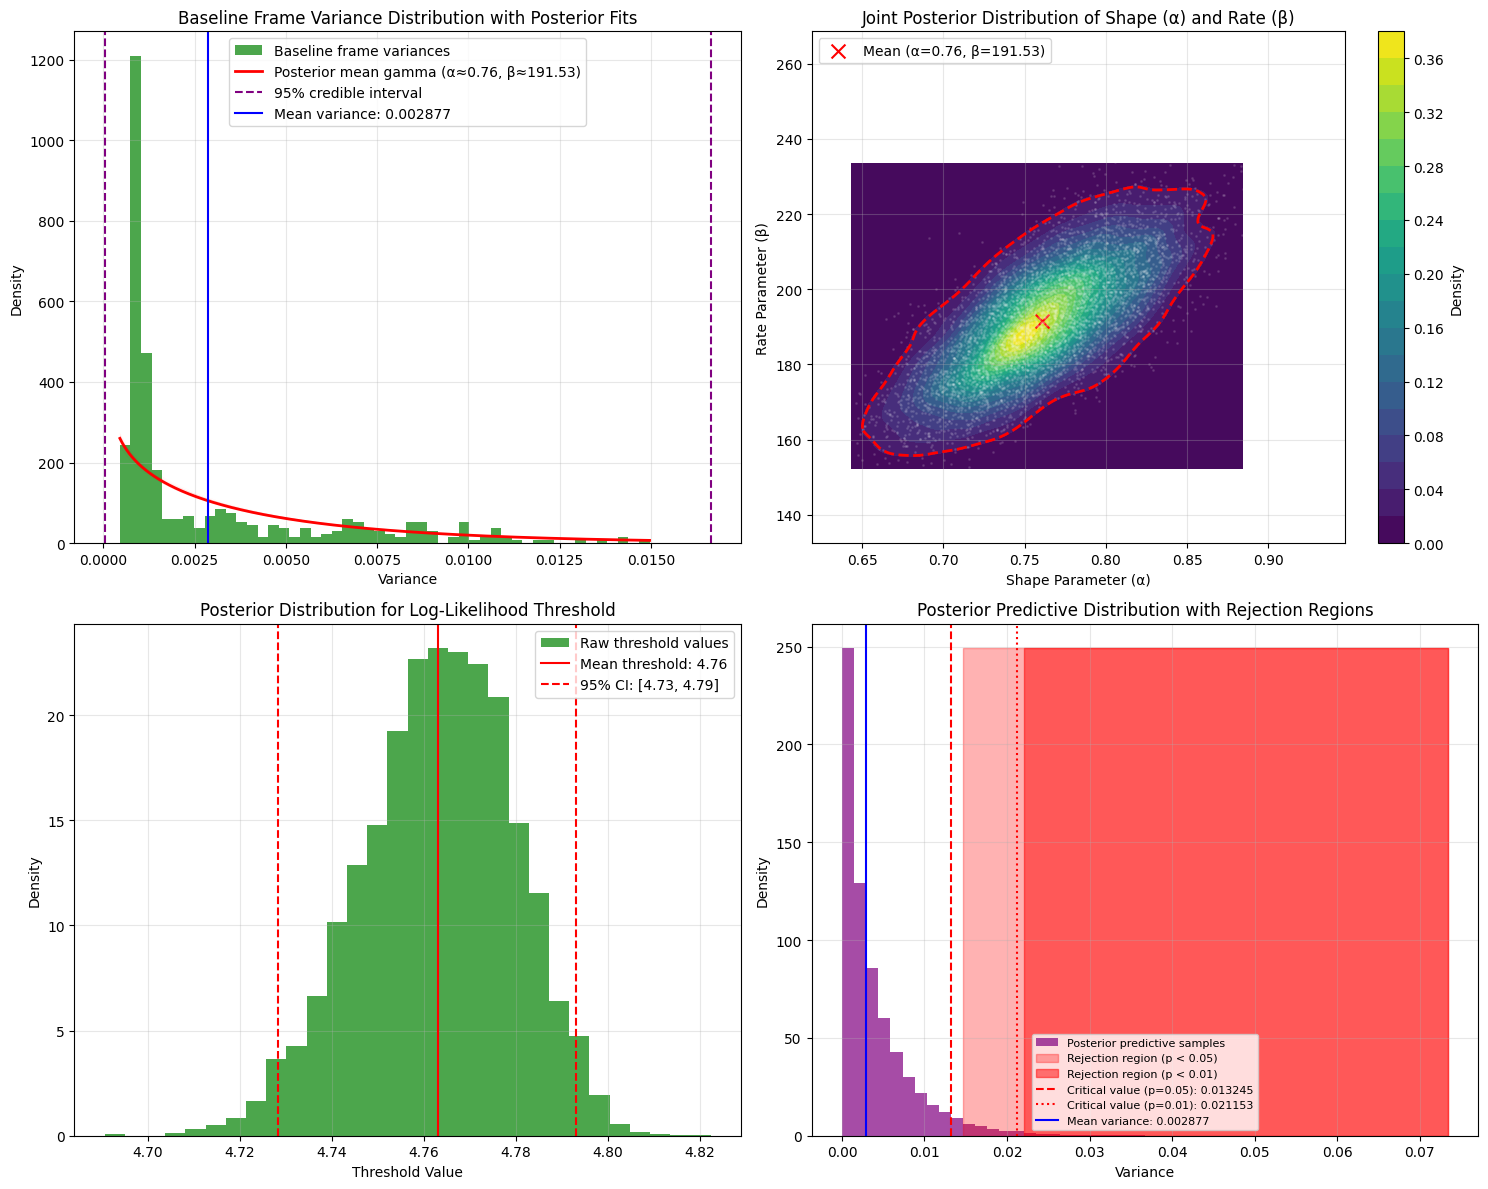

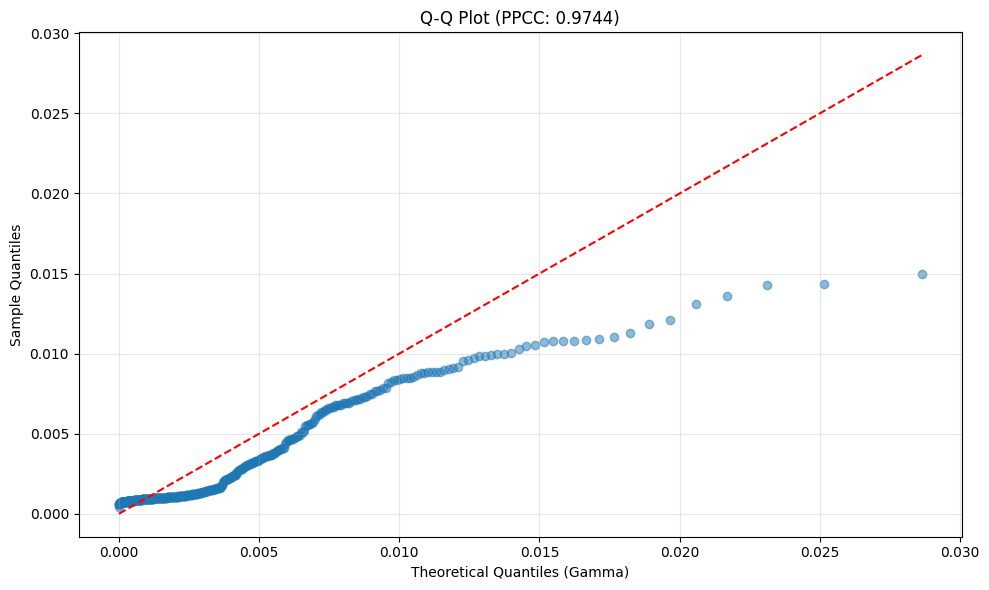

Spearman correlation: r = -0.743, p = 0.022

--- Testing with 2 baseline clips ---
Using 2 baseline clips
Testing 8 clips (including 4 unused good clips)
Starting JAX MCMC sampling...


sample: 100%|██████████| 5500/5500 [00:01<00:00, 2876.17it/s, 7 steps of size 5.83e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.91      0.04      0.91      0.85      0.97   1325.19      1.00
      beta    272.10     14.84    271.78    247.25    295.11   1398.44      1.00

Number of divergences: 0
JAX sampling completed in 2.02 seconds (2470.11 samples/sec)


c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\../src/master\yolo_monitoring.py:468: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',


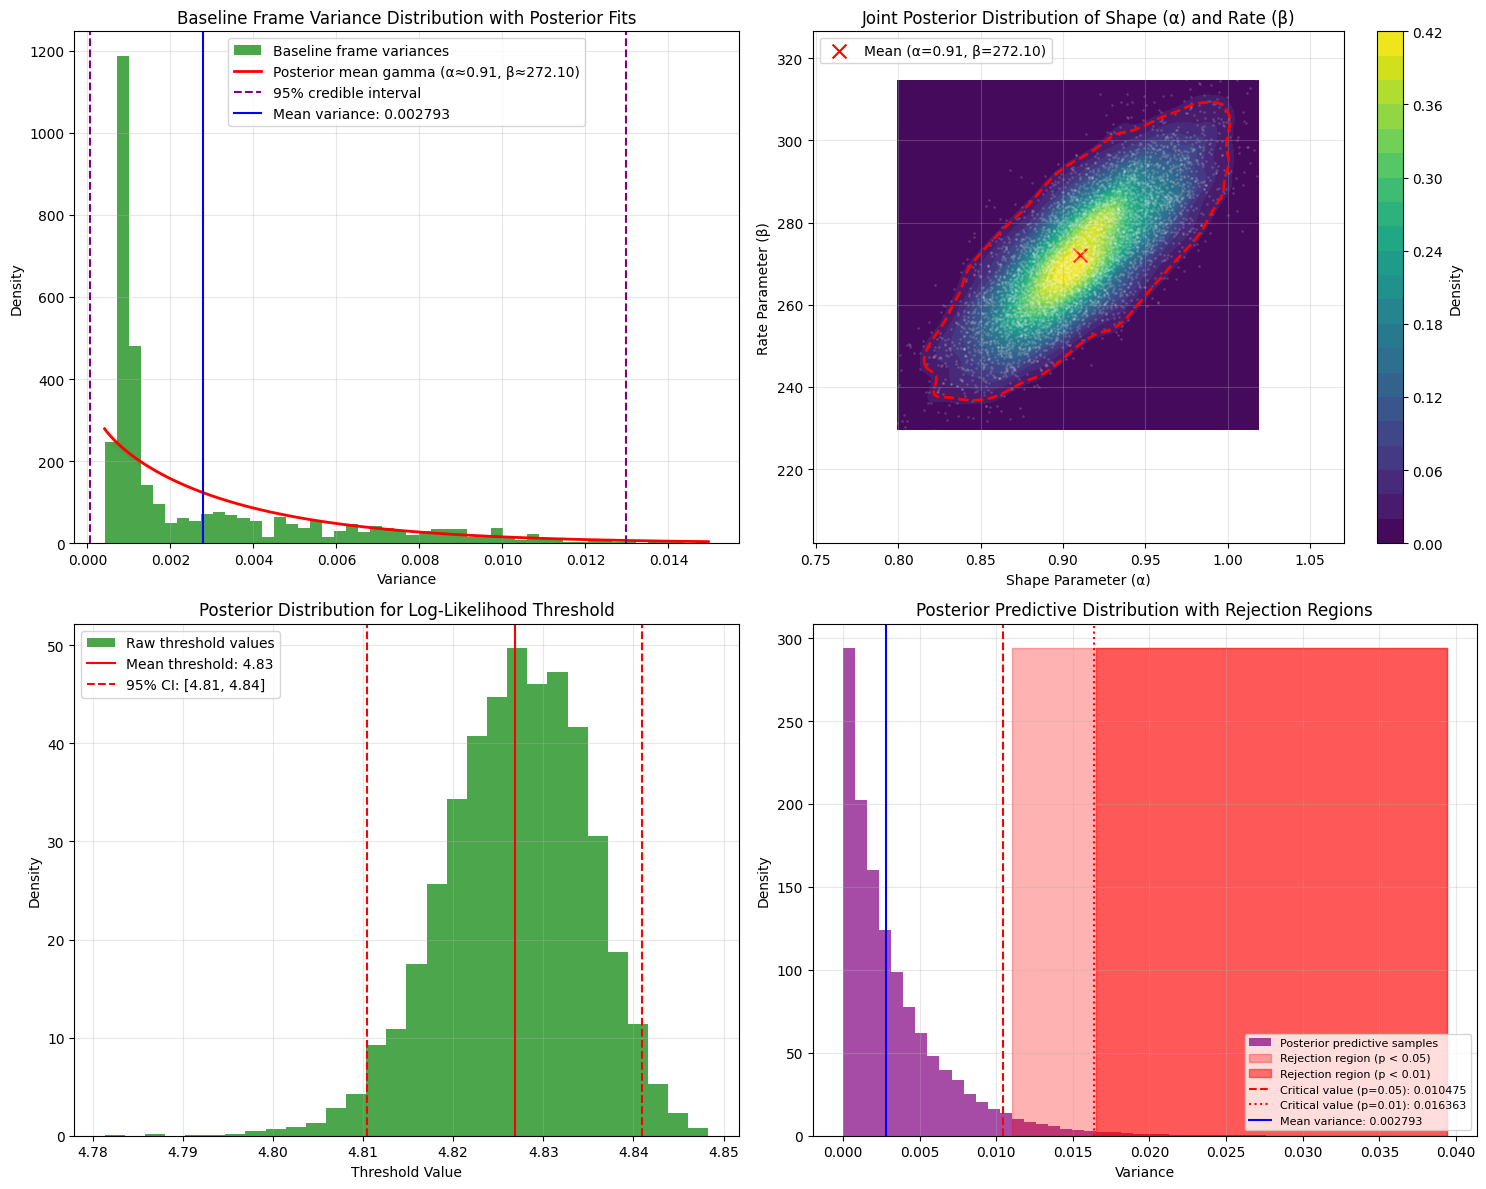

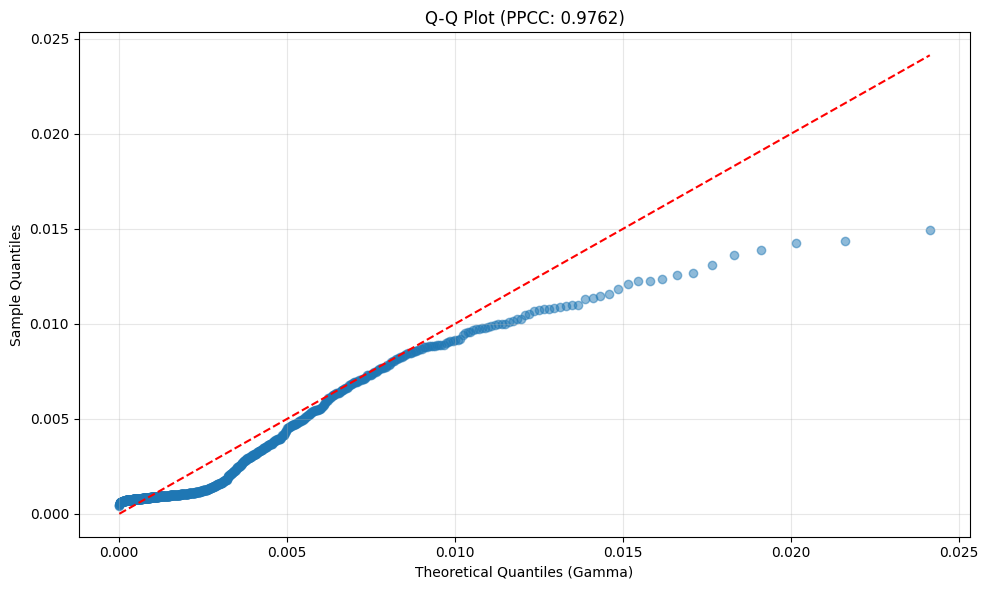

Spearman correlation: r = -0.866, p = 0.005

--- Testing with 3 baseline clips ---
Using 3 baseline clips
Testing 7 clips (including 3 unused good clips)
Starting JAX MCMC sampling...


sample: 100%|██████████| 5500/5500 [00:02<00:00, 2557.78it/s, 7 steps of size 5.51e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.98      0.03      0.98      0.93      1.04   1461.15      1.00
      beta    312.90     13.90    312.81    291.07    336.03   1516.19      1.00

Number of divergences: 0
JAX sampling completed in 2.27 seconds (2203.81 samples/sec)


c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\../src/master\yolo_monitoring.py:468: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',


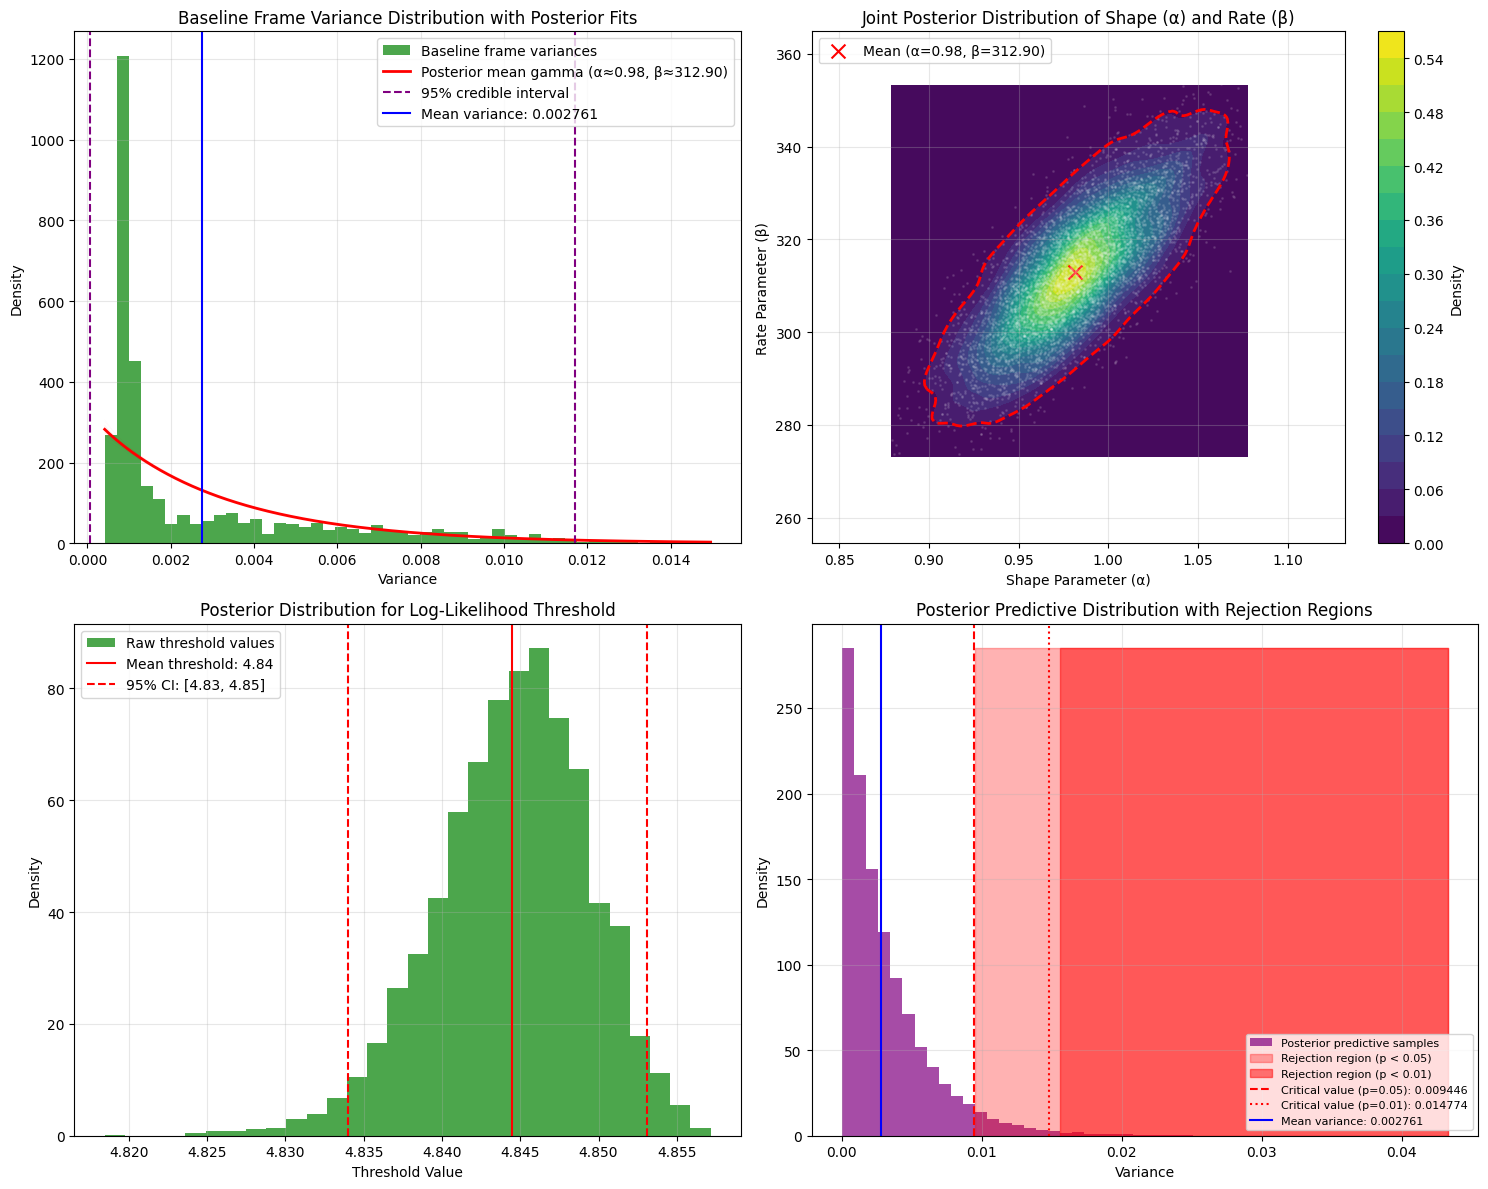

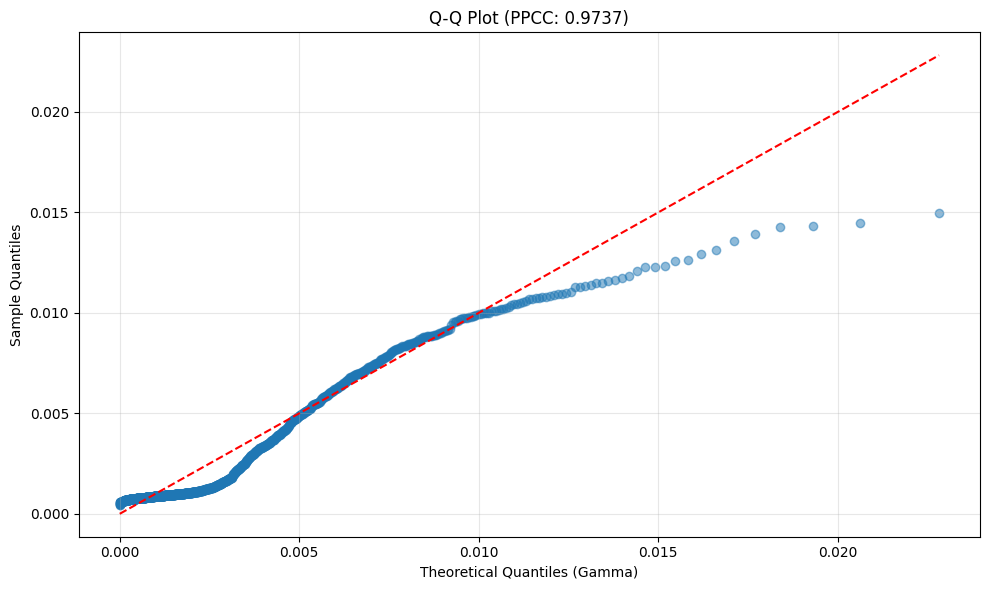

Spearman correlation: r = -0.874, p = 0.010

--- Testing with 4 baseline clips ---
Using 4 baseline clips
Testing 6 clips (including 2 unused good clips)
Starting JAX MCMC sampling...


sample: 100%|██████████| 5500/5500 [00:01<00:00, 2769.78it/s, 11 steps of size 4.52e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.03      0.03      1.03      0.99      1.08   1553.92      1.00
      beta    338.47     12.67    338.33    318.41    359.22   1517.95      1.00

Number of divergences: 0
JAX sampling completed in 2.10 seconds (2375.70 samples/sec)


c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\../src/master\yolo_monitoring.py:468: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',


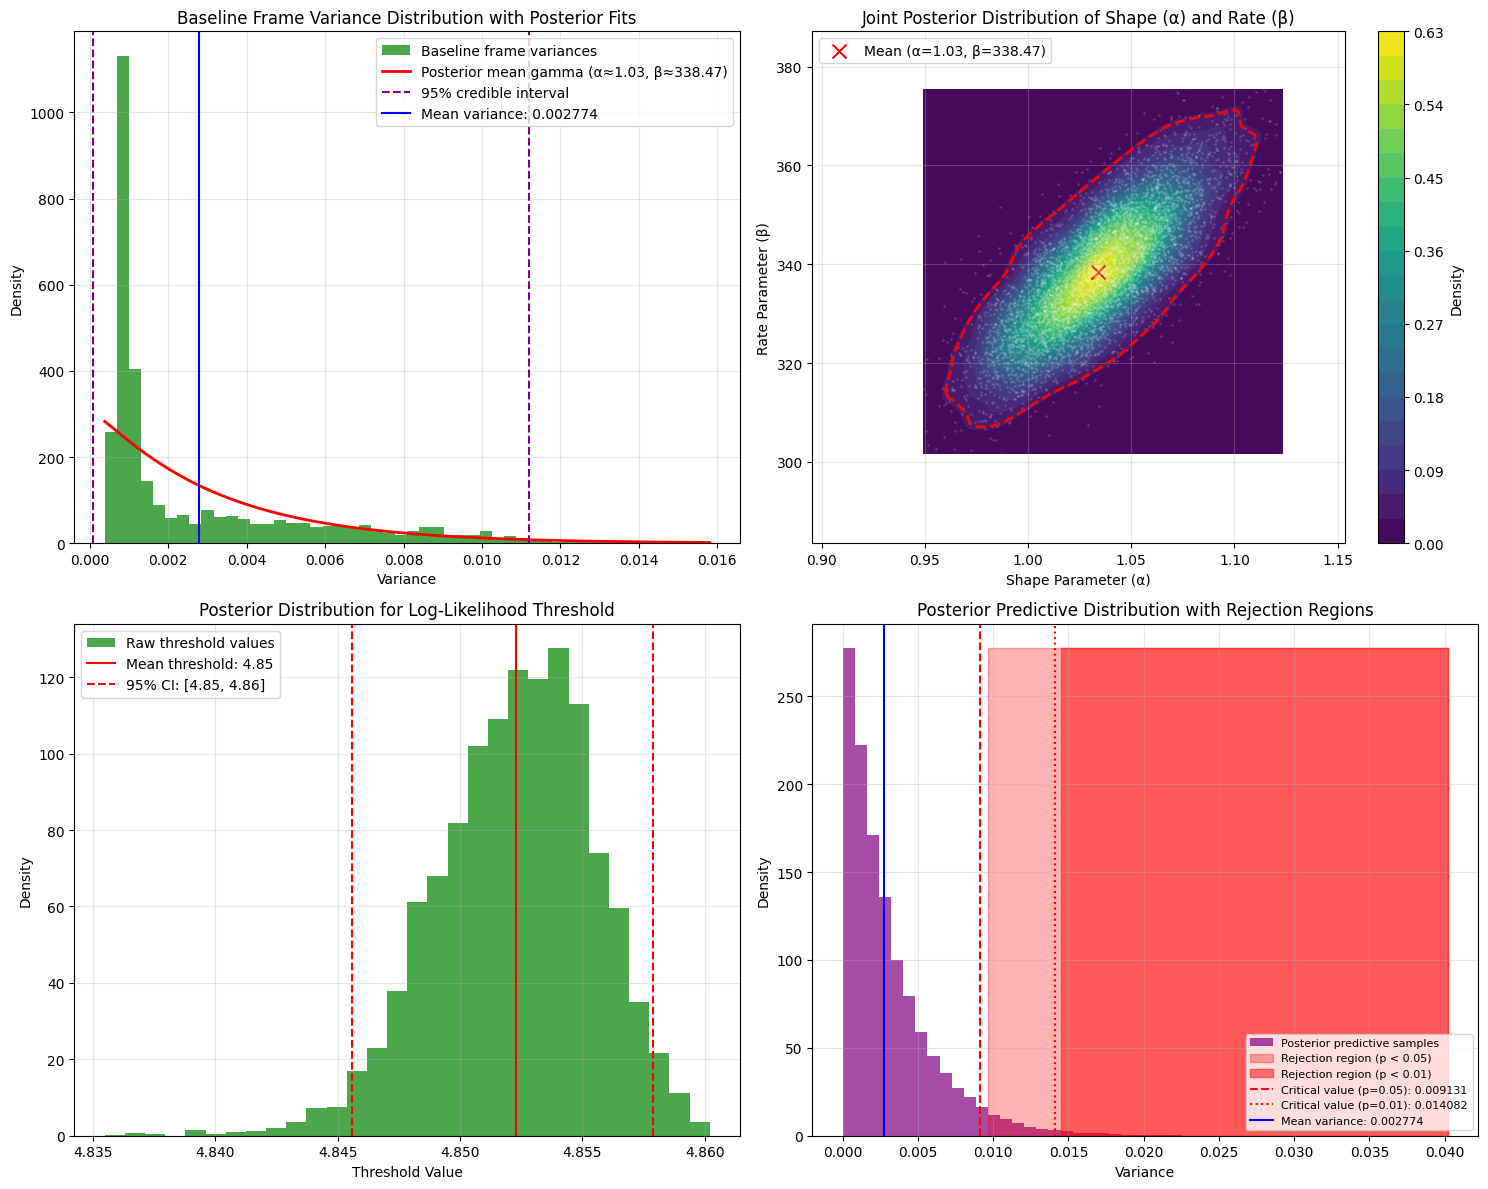

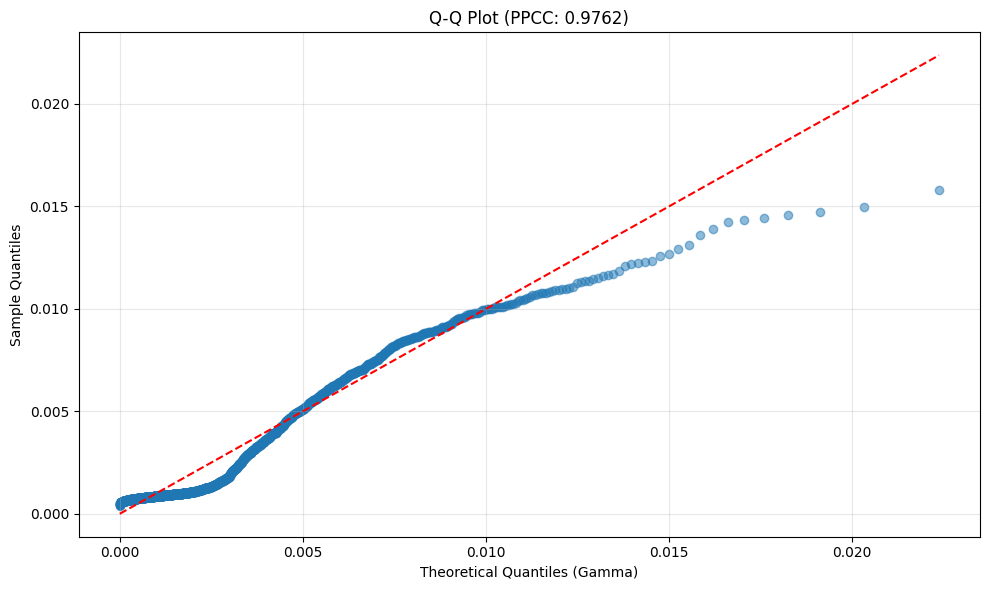

Spearman correlation: r = -0.891, p = 0.017


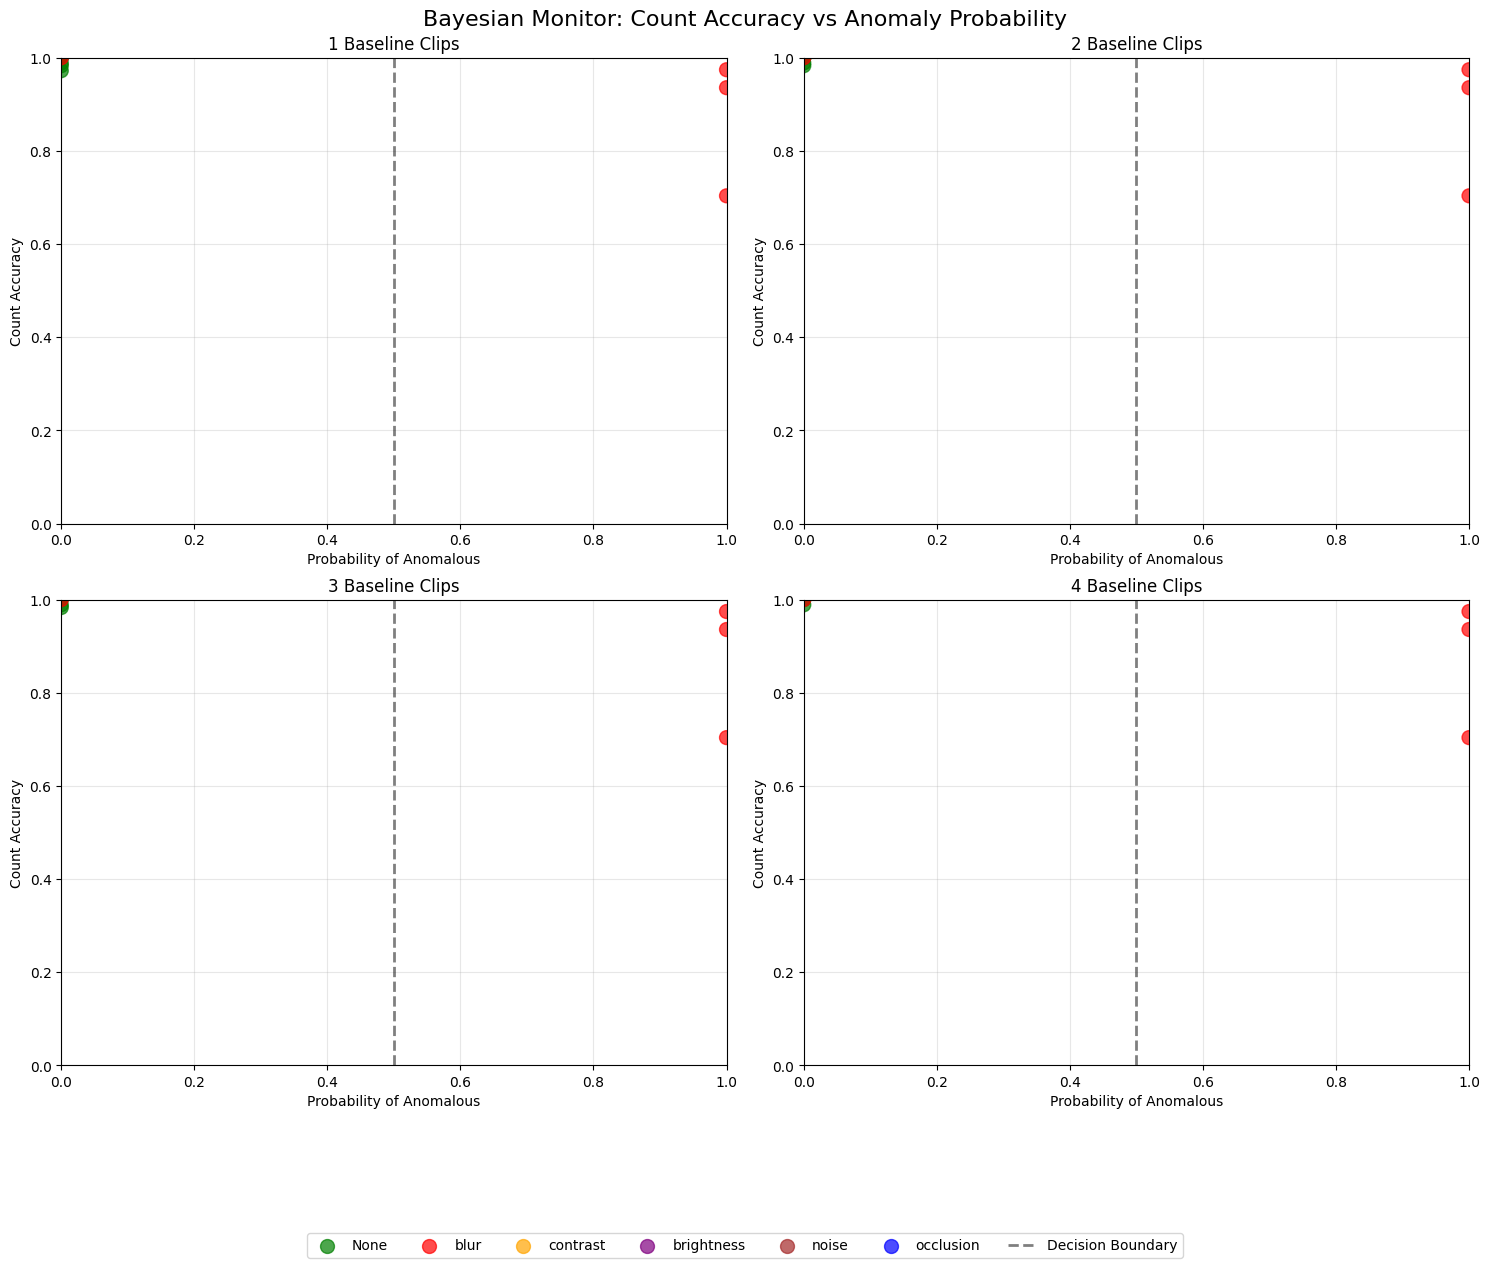


All tests completed successfully!

=== SUMMARY ===
1 baseline clips: Spearman r = -0.743, p = 0.022
2 baseline clips: Spearman r = -0.866, p = 0.005
3 baseline clips: Spearman r = -0.874, p = 0.010
4 baseline clips: Spearman r = -0.891, p = 0.017


In [19]:

filepath = "saved_data/frame_variances.pkl"


all_results = test_all_baseline_sizes(filepath)
print("\nAll tests completed successfully!")

print("\n=== SUMMARY ===")
for n_baseline, _, _, _, corr_r, corr_p in all_results:
    print(f"{n_baseline} baseline clips: Spearman r = {corr_r:.3f}, p = {corr_p:.3f}")

# Asses calibration